In [1]:
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import os
from slicedimage import ImageFormat
from showit import image
import numpy as np
import napari
#import seaborn as sns
import starfish.data

from starfish.morphology import Binarize, Filter, Merge, Segment
from starfish import data,Experiment, FieldOfView, display, IntensityTable
from starfish.experiment.builder import write_experiment_json
from starfish.image import Filter as imFilter
from starfish.image import ApplyTransform, LearnTransform
from starfish.types import Axes, Features, Levels, TraceBuildingStrategies
from starfish.util.plot import diagnose_registration,imshow_plane, intensity_histogram
from starfish.spots import DecodeSpots,FindSpots,DetectPixels,DecodeSpots,AssignTargets
from starfish.core.spots.DecodeSpots.trace_builders import build_spot_traces_exact_match,\
build_traces_sequential, build_traces_nearest_neighbors

In [2]:
maindir='Figures/'
answer=os.path.isdir(maindir)
if answer==True:
	pass
else:
	os.mkdir(maindir)


def segmentCell(imgs,nuclei):
    # set parameters
    dapi_thresh = .18  # global threshold value for nuclei images
    stain_thresh = .22  # global threshold value for primary images
    min_dist = 57  # minimum distance (pixels) between nuclei distance transformed peaks
    min_allowed_size = 10  # minimum size (in pixels) of nuclei
    max_allowed_size = 10000  # maximum size (in pixels) of nuclei

    mp = imgs.reduce({Axes.CH, Axes.ZPLANE}, func="max")
    stain = mp.reduce(
        {Axes.ROUND},
        func="mean",
        level_method=Levels.SCALE_BY_IMAGE)

    nuclei_mp_scaled = nuclei.reduce(
        {Axes.ROUND, Axes.CH, Axes.ZPLANE},
        func="max",
        level_method=Levels.SCALE_BY_IMAGE)

    f = plt.figure(figsize=(12,5))
    ax1 = f.add_subplot(121)
    nuclei_numpy = nuclei_mp_scaled._squeezed_numpy(Axes.ROUND, Axes.CH, Axes.ZPLANE)
    image(nuclei_numpy, ax=ax1, size=20, bar=True)
    plt.title('Nuclei')

    ax2 = f.add_subplot(122)
    image(
        stain._squeezed_numpy(Axes.ROUND, Axes.CH, Axes.ZPLANE),
        ax=ax2, size=20, bar=True)
    plt.title('Stain')
    plt.savefig(maindir+'1Nuclei_staining.png')
    plt.clf()

    binarized_nuclei = Binarize.ThresholdBinarize(dapi_thresh).run(nuclei_mp_scaled)
    labeled_masks = Filter.MinDistanceLabel(min_dist, 1).run(binarized_nuclei)
    watershed_markers = Filter.AreaFilter(min_area=min_allowed_size, max_area=max_allowed_size).run(labeled_masks)

    plt.subplot(121)
    image(
        binarized_nuclei.uncropped_mask(0).squeeze(Axes.ZPLANE.value).values,
        bar=False,
        ax=plt.gca(),
    )
    plt.title('Nuclei Thresholded')

    plt.subplot(122)
    image(
        watershed_markers.to_label_image().xarray.squeeze(Axes.ZPLANE.value).values,
        size=20,
        cmap=plt.cm.nipy_spectral,
        ax=plt.gca(),
    )
    plt.title('Found: {} cells'.format(len(watershed_markers)))
    plt.savefig(maindir+'2nuclei_threshold_watershed_marker.png')
    plt.clf()

    thresholded_stain = Binarize.ThresholdBinarize(stain_thresh).run(stain)
    markers_and_stain = Merge.SimpleMerge().run([thresholded_stain, watershed_markers])
    watershed_mask = Filter.Reduce(
        "logical_or",
        lambda shape: np.zeros(shape=shape, dtype=np.bool)
    ).run(markers_and_stain)

    image(
        watershed_mask.to_label_image().xarray.squeeze(Axes.ZPLANE.value).values,
        bar=False,
        ax=plt.gca(),
    )
    plt.title('Watershed Mask')
    plt.savefig(maindir+'3watershed_mask.png')
    plt.clf()

    segmenter = Segment.WatershedSegment(connectivity=np.ones((1, 3, 3), dtype=np.bool))

    # masks is BinaryMaskCollection for downstream steps
    masks = segmenter.run(
        stain,
        watershed_markers,
        watershed_mask,
    )

    # display result
    image(
        masks.to_label_image().xarray.squeeze(Axes.ZPLANE.value).values,
        size=20,
        cmap=plt.cm.nipy_spectral,
        ax=plt.gca(),
    )
    plt.title('Segmented Cells')
    plt.savefig(maindir+'4segmentedCells.png')
    plt.clf()
    return segmenter,masks


def plot_intensity_histograms_normalize_intensity_values(stack: starfish.ImageStack, r: int,savename: str):
    fig = plt.figure(dpi=150)
    ax1 = fig.add_subplot(231, title='R: 1, ch: 0')
    ax2 = fig.add_subplot(232, title='R: 1, ch: 1', sharex=ax1, sharey=ax1)
    ax3 = fig.add_subplot(233, title='R: 1, ch: 2', sharex=ax1, sharey=ax1)
    ax4 = fig.add_subplot(234, title='R: 2, ch: 0', sharex=ax1, sharey=ax1)
    ax5 = fig.add_subplot(235, title='R: 2, ch: 1', sharex=ax1, sharey=ax1)
    ax6 = fig.add_subplot(236, title='R: 2, ch: 2', sharex=ax1, sharey=ax1)
    intensity_histogram(stack, sel={Axes.ROUND: 0, Axes.CH: 0}, log=True, bins=50, ax=ax1)
    intensity_histogram(stack, sel={Axes.ROUND: 0, Axes.CH: 1}, log=True, bins=50, ax=ax2)
    intensity_histogram(stack, sel={Axes.ROUND: 0, Axes.CH: 2}, log=True, bins=50, ax=ax3)
    intensity_histogram(stack, sel={Axes.ROUND: 1, Axes.CH: 0}, log=True, bins=50, ax=ax4)
    intensity_histogram(stack, sel={Axes.ROUND: 1, Axes.CH: 1}, log=True, bins=50, ax=ax5)
    intensity_histogram(stack, sel={Axes.ROUND: 1, Axes.CH: 2}, log=True, bins=50, ax=ax6)
    fig.tight_layout()
    fig.savefig(maindir+'normalize_intensity_value_'+savename+'.png')


def plot_intensity_histograms_normalize_intensity_distribution(
        ref: starfish.ImageStack, scaled_cr: starfish.ImageStack, scaled_c: starfish.ImageStack,
        scaled_r: starfish.ImageStack, r: int,savename: str):
    fig = plt.figure()
    ax10 = fig.add_subplot(4, 3, 10)
    intensity_histogram(scaled_cr, sel={Axes.ROUND: r, Axes.CH: 0}, log=True, bins=50, ax=ax10)
    ax10.set_ylabel('ch and r', rotation=90, size='large')
    ax11 = fig.add_subplot(4, 3, 11, sharex=ax10)
    intensity_histogram(scaled_cr, sel={Axes.ROUND: r, Axes.CH: 1}, log=True, bins=50, ax=ax11)
    ax12 = fig.add_subplot(4, 3, 12, sharex=ax10)
    intensity_histogram(scaled_cr, sel={Axes.ROUND: r, Axes.CH: 2}, log=True, bins=50, ax=ax12)

    ax1 = fig.add_subplot(4, 3, 1, sharex=ax10)
    intensity_histogram(ref, sel={Axes.ROUND: r, Axes.CH: 0}, log=True, bins=50, ax=ax1)
    ax1.set_title('ch: 0')
    ax1.set_ylabel('unscaled', rotation=90, size='large')
    ax2 = fig.add_subplot(4, 3, 2, sharex=ax10)
    intensity_histogram(ref, sel={Axes.ROUND: r, Axes.CH: 1}, log=True, bins=50, ax=ax2)
    ax2.set_title('ch: 1')
    ax3 = fig.add_subplot(4, 3, 3, sharex=ax10)
    intensity_histogram(ref, sel={Axes.ROUND: r, Axes.CH: 2}, log=True, bins=50, ax=ax3)
    ax3.set_title('ch: 2')

    ax4 = fig.add_subplot(4, 3, 4, sharex=ax10)
    intensity_histogram(scaled_c, sel={Axes.ROUND: r, Axes.CH: 0}, log=True, bins=50, ax=ax4)
    ax4.set_ylabel('ch', rotation=90, size='large')
    ax5 = fig.add_subplot(4, 3, 5, sharex=ax10)
    intensity_histogram(scaled_c, sel={Axes.ROUND: r, Axes.CH: 1}, log=True, bins=50, ax=ax5)
    ax6 = fig.add_subplot(4, 3, 6, sharex=ax10)
    intensity_histogram(scaled_c, sel={Axes.ROUND: r, Axes.CH: 2}, log=True, bins=50, ax=ax6)

    ax7 = fig.add_subplot(4, 3, 7, sharex=ax10)
    intensity_histogram(scaled_r, sel={Axes.ROUND: r, Axes.CH: 0}, log=True, bins=50, ax=ax7)
    ax7.set_ylabel('r', rotation=90, size='large')
    ax8 = fig.add_subplot(4, 3, 8, sharex=ax10)
    intensity_histogram(scaled_r, sel={Axes.ROUND: r, Axes.CH: 1}, log=True, bins=50, ax=ax8)
    ax9 = fig.add_subplot(4, 3, 9, sharex=ax10)
    intensity_histogram(scaled_r, sel={Axes.ROUND: r, Axes.CH: 2}, log=True, bins=50, ax=ax9)
    fig.tight_layout()
    fig.savefig(maindir+'normalize_intensity_distributions_'+savename+'.png')


In [3]:
outputdir='Heart_output/'
e = Experiment.from_json(os.path.join(outputdir, "experiment.json"))

section=[4400,4496,1776,1768]
#section=[4420,4516,1736,1728]

#First and second selection 
y_slice = slice(section[1],section[1]+section[3])
x_first = slice(section[0],section[0]+section[2])

x_slice=x_first
RNA_and_nuclei = e.fov().get_image('primary',x=x_slice, y=y_slice)
nuclei_ref = e.fov().get_image('dots',x=x_slice, y=y_slice)
nuclei = e.fov().get_image('nuclei',x=x_slice, y=y_slice)

#RNA_and_nuclei = e.fov().get_image('primary')
#nuclei_ref = e.fov().get_image('dots')
#nuclei = e.fov().get_image('nuclei')

print('RNA and nuclei channel',RNA_and_nuclei)
print('nuclei reference',nuclei)

imgs=RNA_and_nuclei.sel({Axes.ROUND: (0,5), Axes.CH: (0,2), Axes.ZPLANE: 0})
all_nuclei=RNA_and_nuclei.sel({Axes.ROUND: (0,5), Axes.CH: 3, Axes.ZPLANE: 0})
#negative=RNA_and_nuclei.sel({Axes.ROUND: (), Axes.CH: (0,2), Axes.ZPLANE: 0})

print('RNA imgs',imgs)
print('nuclei from every rounds',all_nuclei)
#print('negative',negative)
print(len(e.codebook))



RNA and nuclei channel <starfish.ImageStack (r: 6, c: 4, z: 1, y: 1768, x: 1776)>
nuclei reference <starfish.ImageStack (r: 1, c: 1, z: 1, y: 1768, x: 1776)>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 44.56it/s]


RNA imgs <starfish.ImageStack (r: 6, c: 3, z: 1, y: 1768, x: 1776)>
nuclei from every rounds <starfish.ImageStack (r: 6, c: 1, z: 1, y: 1768, x: 1776)>
198


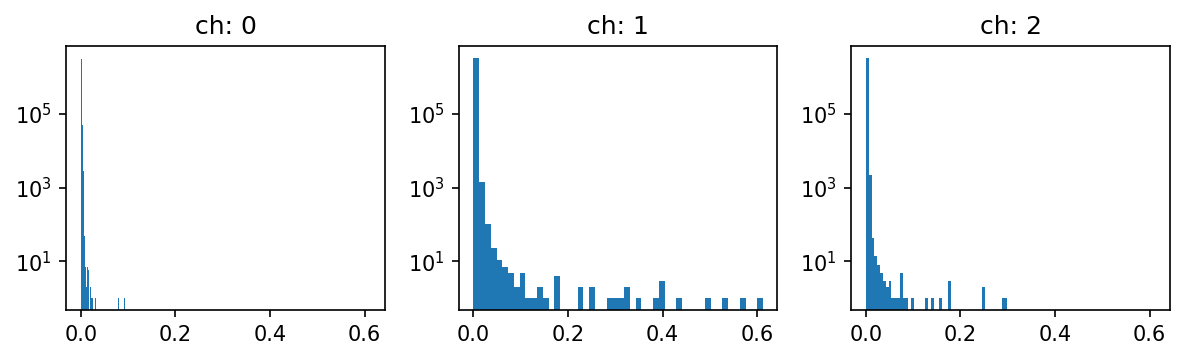

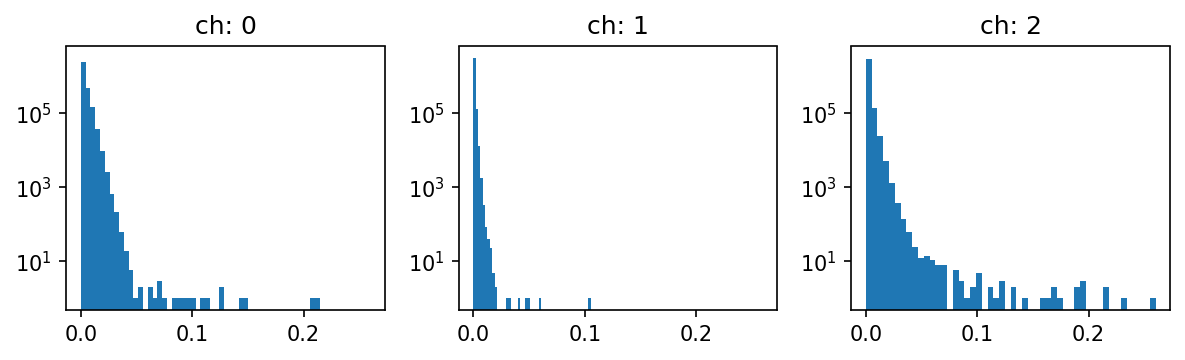

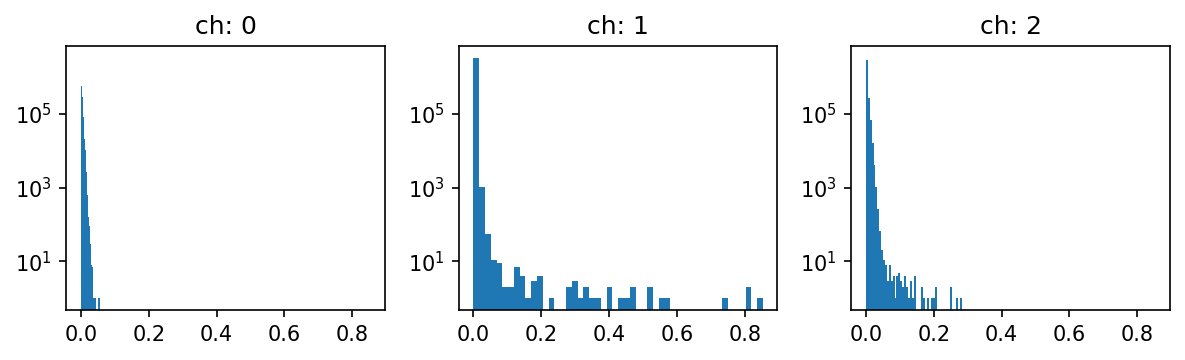

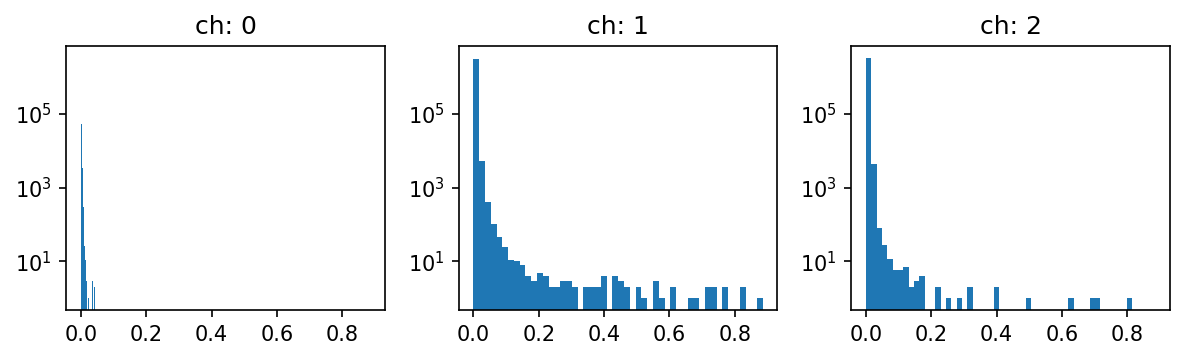

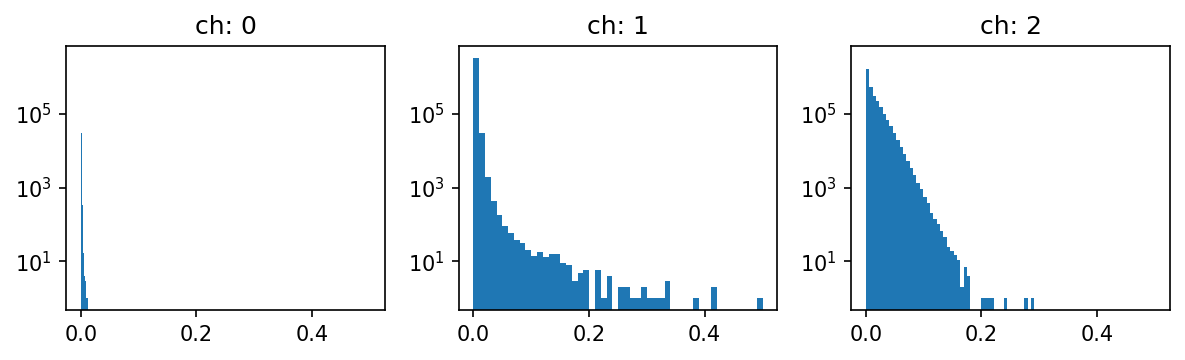

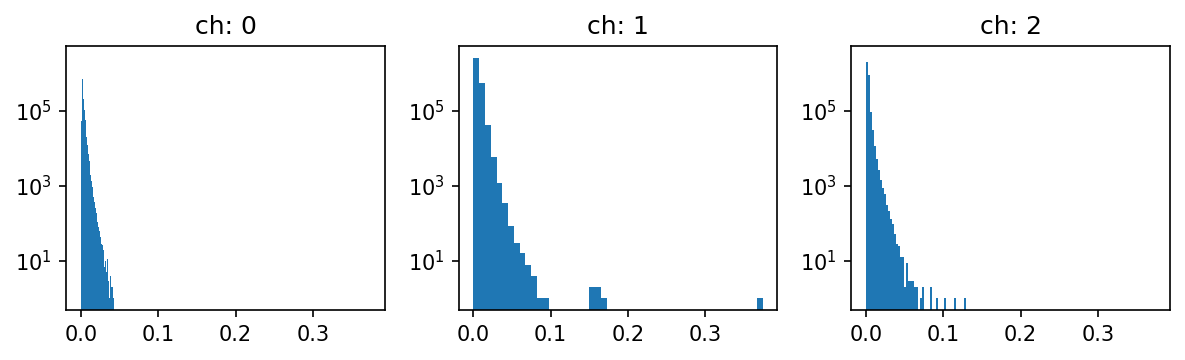

In [4]:
def imshow_3channels(stack: starfish.ImageStack, r: int):
    fig = plt.figure(dpi=150)
    ax1 = fig.add_subplot(131, title='ch: 0')
    ax2 = fig.add_subplot(132, title='ch: 1')
    ax3 = fig.add_subplot(133, title='ch: 2')
    imshow_plane(stack, sel={Axes.ROUND: r, Axes.CH: 0}, ax=ax1)
    imshow_plane(stack, sel={Axes.ROUND: r, Axes.CH: 1}, ax=ax2)
    imshow_plane(stack, sel={Axes.ROUND: r, Axes.CH: 2}, ax=ax3)


def plot_intensity_histograms(stack: starfish.ImageStack, r: int):
    fig = plt.figure(figsize=(8, 2.5),dpi=150)
    ax1 = fig.add_subplot(131, title='ch: 0')
    ax2 = fig.add_subplot(132, title='ch: 1', sharex=ax1, sharey=ax1)
    ax3 = fig.add_subplot(133, title='ch: 2', sharex=ax1, sharey=ax1)
    intensity_histogram(stack, sel={Axes.ROUND: r, Axes.CH: 0}, log=True, bins=50, ax=ax1)
    intensity_histogram(stack, sel={Axes.ROUND: r, Axes.CH: 1}, log=True, bins=50, ax=ax2)
    intensity_histogram(stack, sel={Axes.ROUND: r, Axes.CH: 2}, log=True, bins=50, ax=ax3)
    fig.tight_layout()

#imshow_3channels(stack=imgs, r=1)
plot_intensity_histograms(stack=imgs, r=0)  
plot_intensity_histograms(stack=imgs, r=1)  
plot_intensity_histograms(stack=imgs, r=2)   
plot_intensity_histograms(stack=imgs, r=3)    
plot_intensity_histograms(stack=imgs, r=4)    
plot_intensity_histograms(stack=imgs, r=5)    

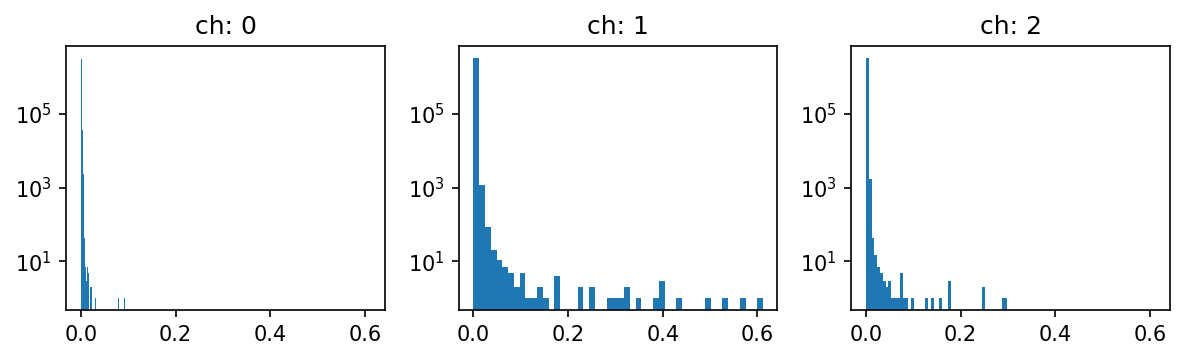

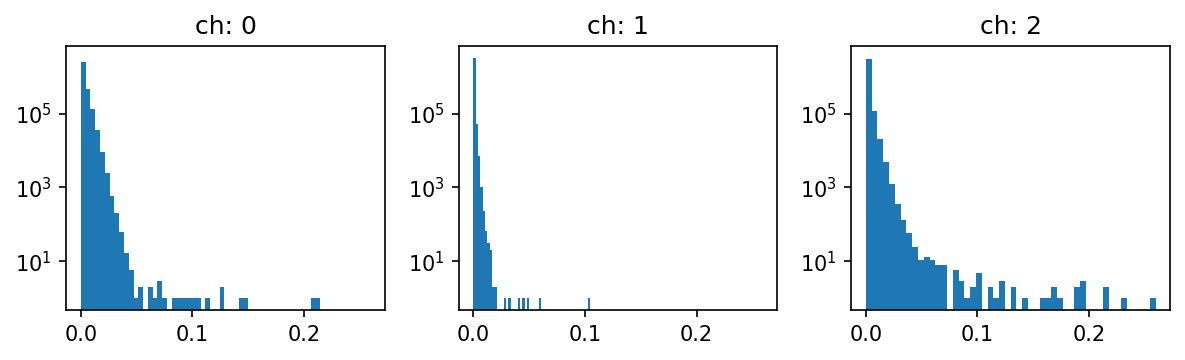

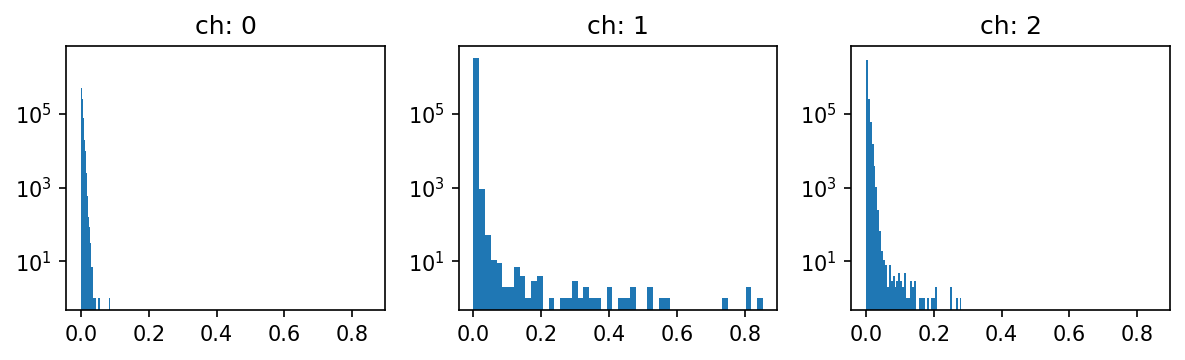

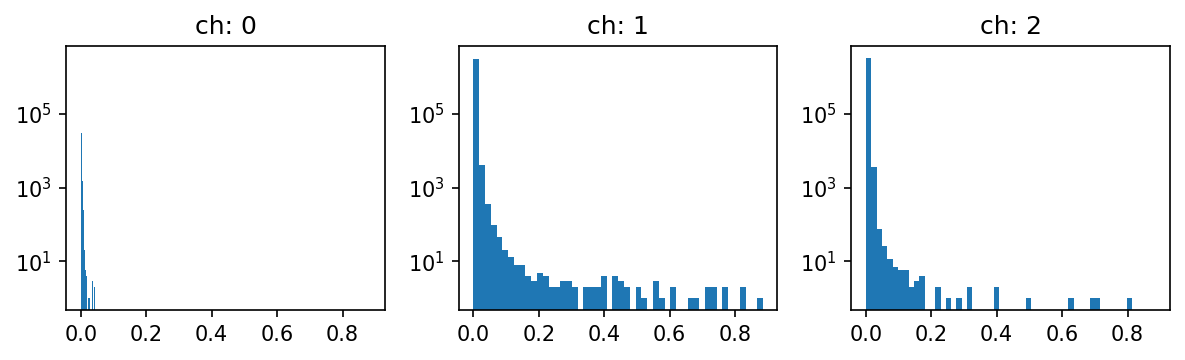

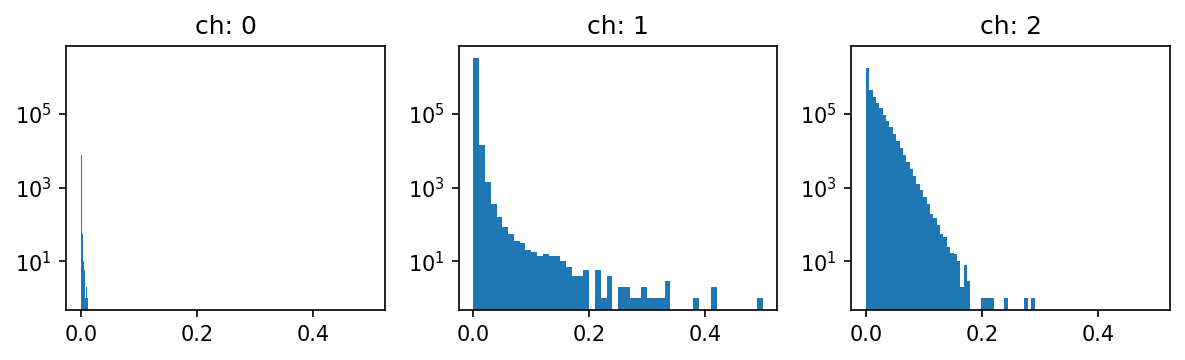

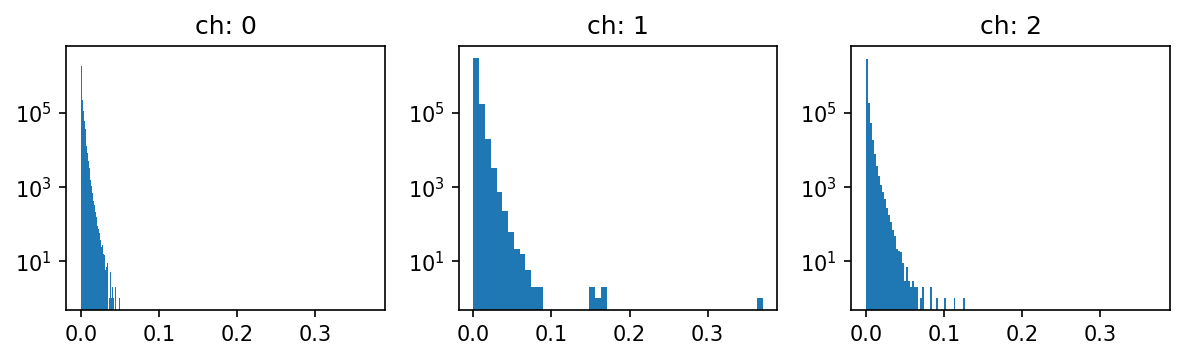

In [5]:
masking_radius=15
filt=imFilter.WhiteTophat(masking_radius,is_volume=False)
WTH=filt.run(imgs,in_place=False)

plot_intensity_histograms(stack=WTH, r=0)  
plot_intensity_histograms(stack=WTH, r=1)  
plot_intensity_histograms(stack=WTH, r=2)   
plot_intensity_histograms(stack=WTH, r=3)    
plot_intensity_histograms(stack=WTH, r=4)    
plot_intensity_histograms(stack=WTH, r=5) 

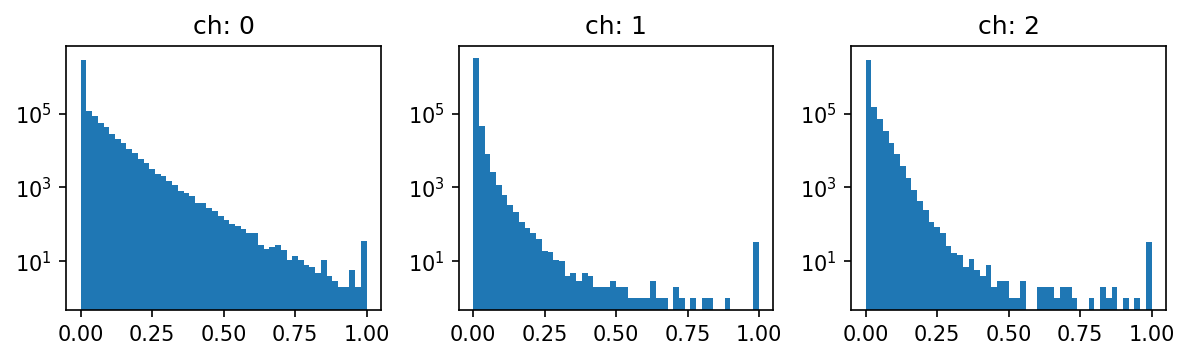

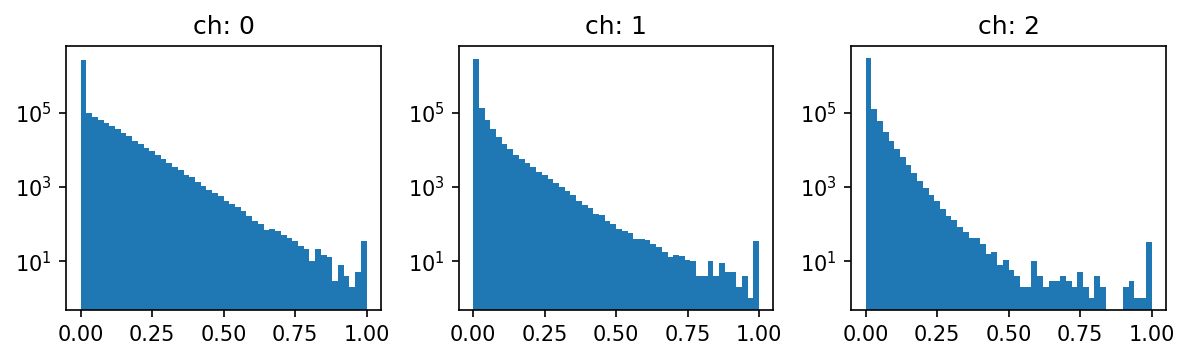

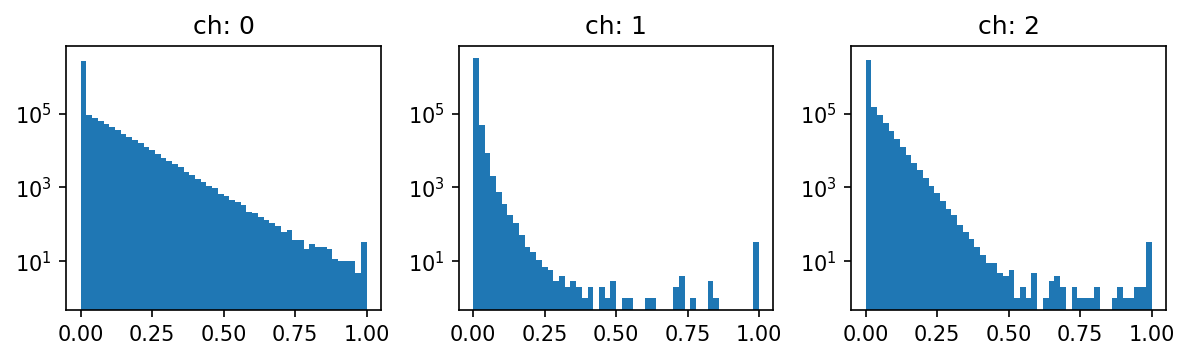

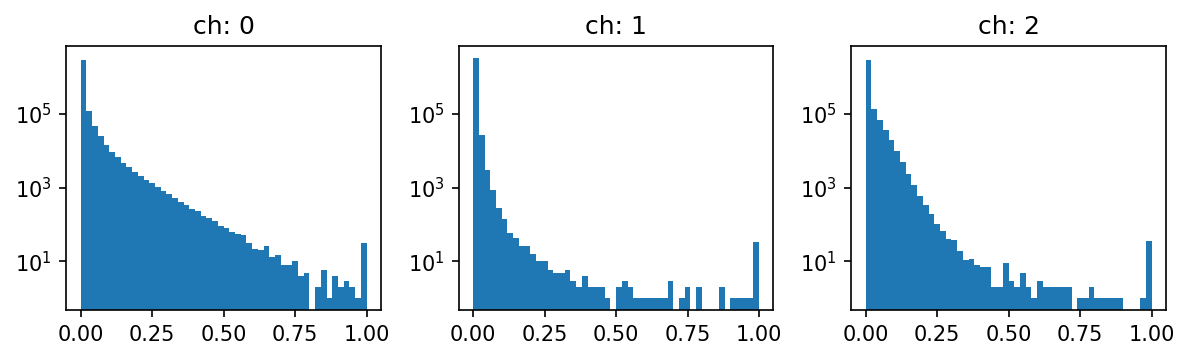

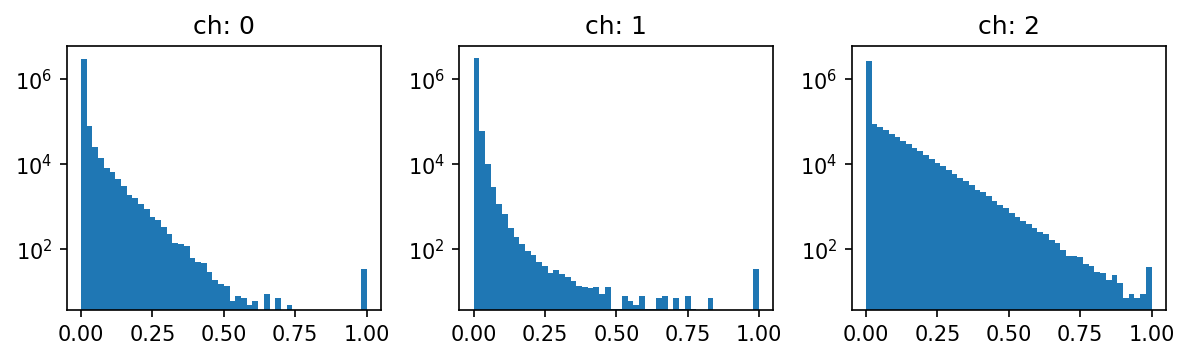

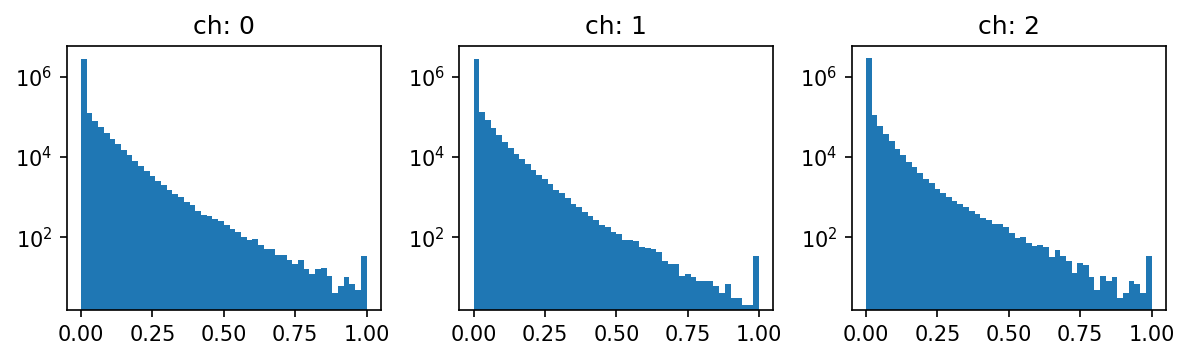

In [6]:
clipper= imFilter.ClipPercentileToZero(p_min=80, p_max=99.999, level_method=Levels.SCALE_BY_CHUNK)
clip_value_to_zero = clipper.run(WTH, in_place=False)
plot_intensity_histograms(stack=clip_value_to_zero, r=0)  
plot_intensity_histograms(stack=clip_value_to_zero, r=1)  
plot_intensity_histograms(stack=clip_value_to_zero, r=2)   
plot_intensity_histograms(stack=clip_value_to_zero, r=3)    
plot_intensity_histograms(stack=clip_value_to_zero, r=4)    
plot_intensity_histograms(stack=clip_value_to_zero, r=5) 

In [7]:
%gui qt 
display(stack=imgs)

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 883.5, 887.5), zoom=0.25093325791855203, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0, 0.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=5, ndisplay=2, last_used=0, range=((0.0, 6.0, 1.0), (0.0, 3.0, 1.0), (0.0, 1.0, 1.0), (0.0, 1768.0, 1.0), (0.0, 1776.0, 1.0)), current_step=(3, 1, 0, 884, 888), order=(0, 1, 2, 3, 4), axis_labels=('0', '1', '2', 'y', 'x')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'stack' at 0x7f2e082702d0>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, unit=None), text_overlay=TextOverlay(visible=False, color=array([0.5, 0.5, 0.5, 1. ]), font_size=10.0, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), overlays=Overlays(interaction_

tile indices: {<Axes.ROUND: 'r'>: 0}
translation: y=0.0, x=0.0, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 1}
translation: y=-40.691, x=-14.613, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 2}
translation: y=-1.312, x=-29.272, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 3}
translation: y=-77.102, x=-15.55, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 4}
translation: y=-95.608, x=-5.417, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 5}
translation: y=-154.927, x=-32.453, rotation: 0.0, scale: 1.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 248.01it/s]


Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 883.5, 887.5), zoom=0.25093325791855203, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0, 0.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=5, ndisplay=2, last_used=0, range=((0.0, 6.0, 1.0), (0.0, 1.0, 1.0), (0.0, 1.0, 1.0), (0.0, 1768.0, 1.0), (0.0, 1776.0, 1.0)), current_step=(3, 0, 0, 884, 888), order=(0, 1, 2, 3, 4), axis_labels=('0', '1', '2', 'y', 'x')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'stack' at 0x7f2e08100e90>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, unit=None), text_overlay=TextOverlay(visible=False, color=array([0.5, 0.5, 0.5, 1. ]), font_size=10.0, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), overlays=Overlays(interaction_

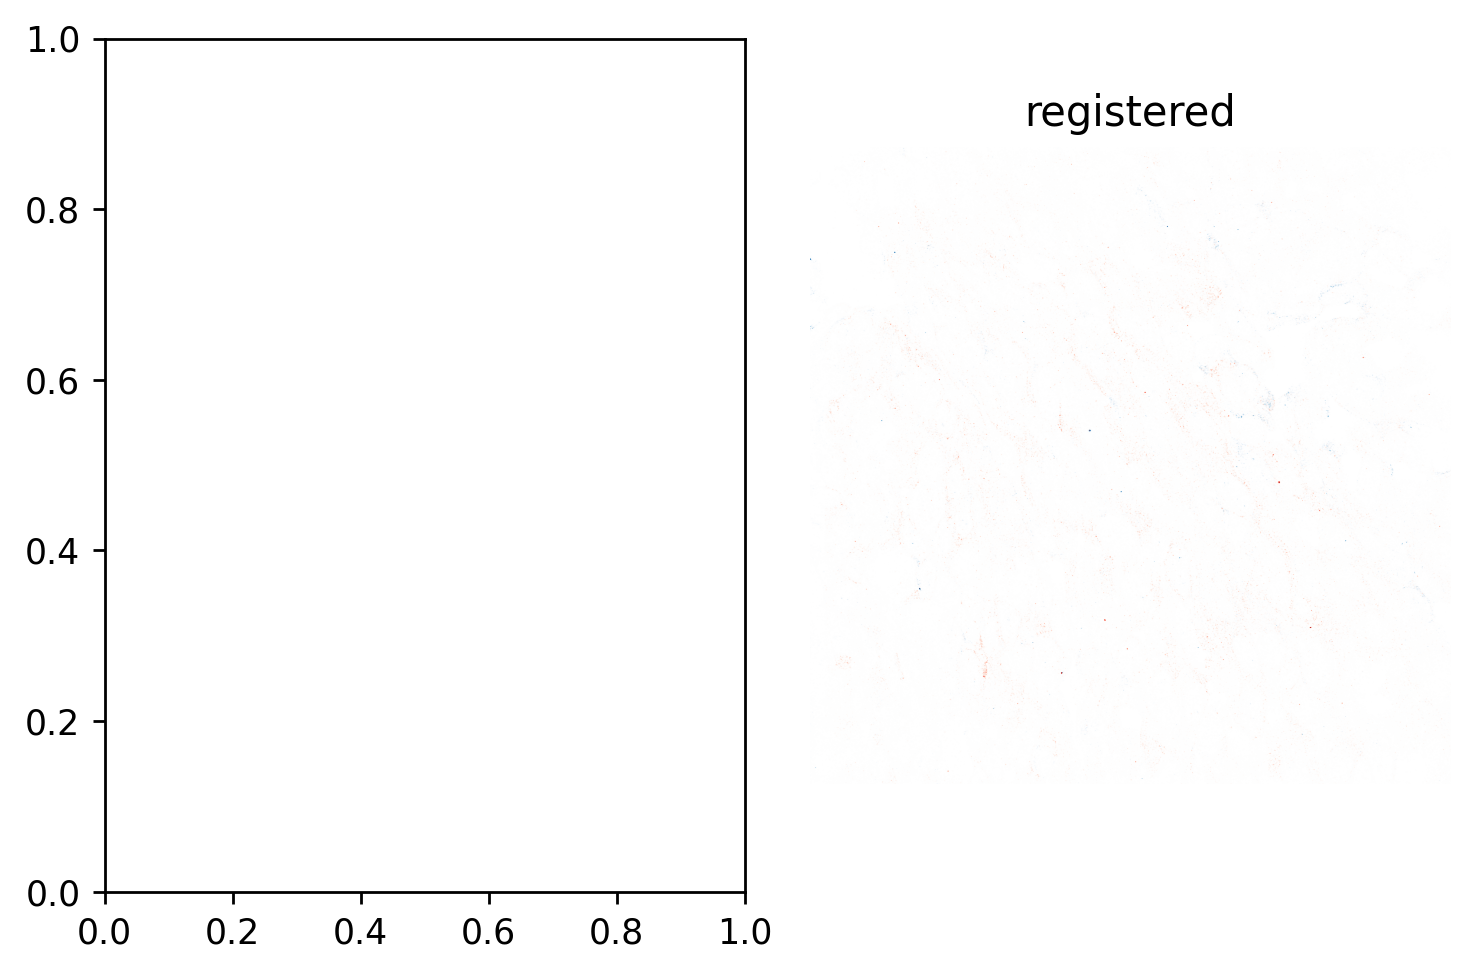

In [10]:
before_registeration=clip_value_to_zero
#before_registeration=low_passed
#before_registeration=scaled_c
f,(ax1,ax2)=plt.subplots(ncols=2)
matplotlib.rcParams["figure.dpi"] = 250
#diagnose_registration(before_registeration.reduce({Axes.CH}, func="max"), {Axes.ROUND:0}, {Axes.ROUND:1},ax=ax1,title='pre-registered', vmin=0, vmax=255)
learn_translation = LearnTransform.Translation(reference_stack=nuclei_ref, axes=Axes.ROUND, upsampling=1000)
transforms_list = learn_translation.run(all_nuclei)
transforms_list.to_json('transforms_list.json')
print(transforms_list)
warp = ApplyTransform.Warp()
registered_nuclei = warp.run(all_nuclei, transforms_list=transforms_list, in_place=False)
#registered_imgs = warp.run(before_registeration, transforms_list=transforms_list, in_place=False)
diagnose_registration(registered_imgs.reduce({Axes.CH}, func="max"), {Axes.ROUND:0}, {Axes.ROUND:1},ax=ax2,title='registered')
f.tight_layout()
f.savefig(maindir+'Registration.png')

%gui qt
#display(stack=registered_imgs)
display(stack=registered_nuclei)


In [11]:
dots=registered_imgs.reduce({Axes.ROUND,Axes.CH}, func="max")
print('dots',dots)
%gui qt
#display(stack=registered_imgs)
display(stack=dots)

dots <starfish.ImageStack (r: 1, c: 1, z: 1, y: 1768, x: 1776)>


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 259.90it/s]


Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 883.5, 887.5), zoom=0.25093325791855203, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0, 0.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=5, ndisplay=2, last_used=0, range=((0.0, 1.0, 1.0), (0.0, 1.0, 1.0), (0.0, 1.0, 1.0), (0.0, 1768.0, 1.0), (0.0, 1776.0, 1.0)), current_step=(0, 0, 0, 884, 888), order=(0, 1, 2, 3, 4), axis_labels=('0', '1', '2', 'y', 'x')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'stack' at 0x7f2d7a758050>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, unit=None), text_overlay=TextOverlay(visible=False, color=array([0.5, 0.5, 0.5, 1. ]), font_size=10.0, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), overlays=Overlays(interaction_

In [44]:
def find_spots(imgs,dots):
    p = FindSpots.BlobDetector(
        #min_sigma=(1, 1,1, 1,1,1),
        #max_sigma=(10, 10, 10,10,10,10),
        #num_sigma=30,
        #threshold=0.1,
        #is_volume=False,
        #measurement_type='mean',

        min_sigma=(1, 1, 1), # old one 1,8,30
        max_sigma=(2.0, 2.0, 2.0),
        num_sigma=10,
        threshold=0.01,
        measurement_type='max',
        is_volume=False,
        #threshold=np.percentile(np.ravel(imgs.xarray.values), 90)
    )
    spots_from_stack = p.run(image_stack=imgs,reference_image=dots)
    '''
    #spots from nearest neighbor with stack
    print('\nC: Build trace with NEAREST_NEIGHBORS')
    print(build_traces_nearest_neighbors(spots_from_stack, search_radius=5))

    #spots from nearest neighbor with reference
    print('\nD: Build trace with NEAREST_NEIGHBORS')
    print(build_traces_nearest_neighbors(spots_from_ref, search_radius=5))
    '''
    return spots_from_stack

In [45]:
#seg,masks=segmentCell(registered_imgs,nuclei)
masks=nuclei 
spots = find_spots(registered_imgs,dots)

In [46]:
def decode_spots(codebook, spots):
    #decoder = DecodeSpots.MetricDistance(codebook=codebook,max_distance=1,min_intensity=1,metric='euclidean',
    #           norm_order=2,trace_building_strategy=TraceBuildingStrategies.EXACT_MATCH)
    
    #decoder = DecodeSpots.MetricDistance(codebook=codebook,max_distance=0.2,min_intensity=0.1,
    #           trace_building_strategy=TraceBuildingStrategies.NEAREST_NEIGHBOR)
    
    decoder = DecodeSpots.MetricDistance(codebook=codebook,max_distance=1,min_intensity=0.0,metric='euclidean',
              norm_order=2,trace_building_strategy=TraceBuildingStrategies.EXACT_MATCH)
    
    #decoder= DecodeSpots.PerRoundMaxChannel(codebook=codebook,anchor_round=0,search_radius=100,
    #                              trace_building_strategy=TraceBuildingStrategies.NEAREST_NEIGHBOR)
        
    #decoder= DecodeSpots.PerRoundMaxChannel(codebook=codebook,anchor_round=0,search_radius=100,
    #                              trace_building_strategy=TraceBuildingStrategies.EXACT_MATCH)    
  
    
    #decoded = initial_spot_intensities.loc[spots[Features.PASSES_THRESHOLDS]]
    #decoded_filtered = decoded[decoded.target != 'nan']
    #decoder = DecodeSpots.SimpleLookupDecoder(codebook=codebook)
    return decoder.run(spots=spots)

def make_expression_matrix(masks, decoded):
    #decoded_filtered = decoded["fov_000"].loc[decoded["fov_000"][Features.PASSES_THRESHOLDS]]
    al = AssignTargets.Label()
    labeled = al.run(masks, decoded[decoded.target != 'nan'])
    labeled_filtered = labeled[labeled.cell_id != 'nan']
    cg=labeled_filtered.to_expression_matrix()
    return labeled_filtered,cg

genes and len sum counts 198 198 100239
Ackr2 	 55
Acsm2 	 262
Actc1 	 20075
Ankrd1 	 140
Aqp1 	 607
Areg 	 1738
Ascl4 	 80
Aurkb 	 45
Calca 	 150
Ccl11 	 176
Ccl17 	 291
Ccl2 	 167
Ccl21a 	 106
Ccl4 	 30
Ccl5 	 354
Ccl7 	 256
Ccr2 	 807
Cd19 	 270
Cd209a 	 213
Cd209f 	 62
Cd209g 	 27
Cd24a 	 111
Cd28 	 396
Cd3e 	 215
Cd4 	 16
Cd59a 	 30
Cd80 	 14
Cd86 	 32
Cd8a 	 189
Cdc6 	 24
Chat 	 191
Chil3 	 66
Clcf1 	 23
Cldn1 	 521
Clec3b 	 471
Clec4b1 	 184
Cox7c 	 94
Cpa3 	 200
Cryab 	 697
Cspg4 	 766
Ctla4 	 28
Cx3cr1 	 22
Cxcl10 	 123
Cxcl12 	 92
Cxcl14 	 495
Cxcl9 	 37
Cytl1 	 42
Dact2 	 135
Ddc 	 593
Dio2 	 370
Dlk1 	 70
Dnm3os 	 213
Ear2 	 577
Ebf1 	 96
Efnb2 	 1118
Ephb4 	 568
Esm1 	 5
Ets1 	 169
Fabp4 	 142
Flt1 	 899
Flt3 	 127
Foxp3 	 15
Gas7 	 199
Gata3 	 368
Gcsam 	 223
Gdf15 	 265
Gypa 	 32
Gzma 	 1607
Gzmc 	 145
H19 	 3991
H2-Eb1 	 22
H2ac10 	 52
Has2 	 126
Hbegf 	 342
Hdc 	 39
Hspb1 	 44
Ifit2 	 700
Ifit3 	 260
Ifitm6 	 451
Igfbp3 	 37
Igfbp5 	 2135
Igkc 	 506
Iglc1 	 10
Iigp1 	 

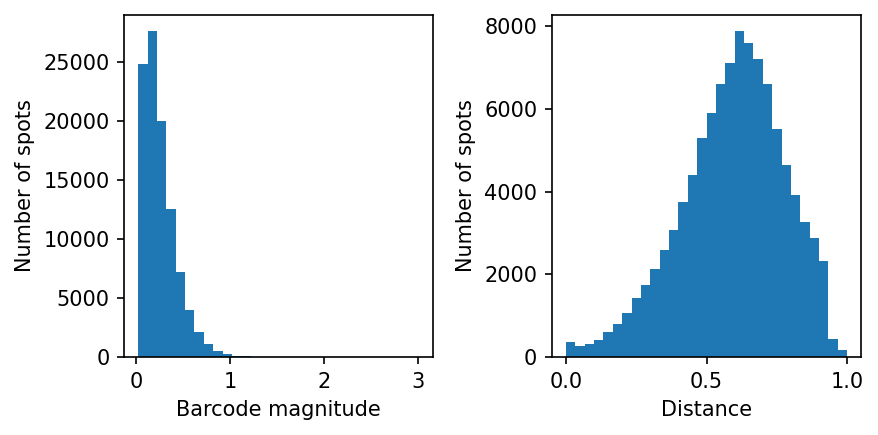

In [47]:
decoded = decode_spots(e.codebook, spots)
decoded = decoded.loc[decoded[Features.PASSES_THRESHOLDS]]

genes, counts = np.unique(decoded.loc[decoded[Features.PASSES_THRESHOLDS]][Features.TARGET], return_counts=True)
print('genes and len sum counts', len(genes),len(counts),sum(counts))
for i in range(len(genes)):
    print(genes[i],'\t',counts[i])
   
table=decoded.to_features_dataframe()
np.savetxt('gene_counts_and_location_.dat',table,fmt="%s",delimiter=",")
print('Table',table.shape)

# Build IntensityTable with same TraceBuilder as was used in MetricDistance
intensities = build_spot_traces_exact_match(spots)
# Get vector magnitudes
norm_intensities, vector_magnitude = e.codebook._normalize_features(intensities, norm_order=2)
# Get distances
distances = decoded.to_decoded_dataframe().data['distance'].to_numpy()
# Plot histogram
matplotlib.rcParams["figure.dpi"] = 150
f, (ax1, ax2) = plt.subplots(ncols=2,figsize=(6,3))
ax1.hist(vector_magnitude, bins=30)
ax1.set_xlabel('Barcode magnitude')
ax1.set_ylabel('Number of spots')
ax2.hist(distances, bins=30)
ax2.set_xlabel('Distance')
ax2.set_ylabel('Number of spots')
f.tight_layout()
f.savefig('metricDisance.png')


In [16]:
table


,intensity,z,y,x,radius,spot_id,z_min,z_max,y_min,y_max,x_min,x_max,features,xc,yc,zc,target,distance,passes_thresholds
0,0.002299,0,1767,1775,4.0,0,0,1,1764,1768,1772,1776,0,0.000072,0.000073,0.00005,Rorc,0.666940,True
1,0.005604,0,1767,1759,3.0,1,0,1,1765,1768,1757,1762,1,0.000072,0.000073,0.00005,Actc1,0.579746,True
2,0.005254,0,1767,1749,2.0,2,0,1,1766,1768,1748,1751,2,0.000072,0.000073,0.00005,Pcsk1,0.704068,True
3,0.042031,0,1767,1743,2.0,3,0,1,1766,1768,1742,1745,3,0.000072,0.000073,0.00005,fake1,0.210671,True
4,0.000000,0,1767,1722,2.0,4,0,1,1766,1768,1721,1724,4,0.000072,0.000073,0.00005,Areg,0.823666,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97707,0.114419,0,0,244,2.0,97830,0,1,0,2,243,246,97830,0.000054,0.000053,0.00005,fake1,0.008290,True
97708,0.034442,0,0,209,2.0,97831,0,1,0,2,208,211,97831,0.000054,0.000053,0.00005,fake1,0.004721,True
97709,0.022767,0,0,190,2.0,97832,0,1,0,2,189,192,97832,0.000054,0.000053,0.00005,fake1,0.004273,True
97710,0.000000,0,0,169,4.0,97833,0,1,0,4,166,173,97833,0.000054,0.000053,0.00005,fake3,0.014308,True


In [119]:
%gui qt
col1a1_spots = decoded[decoded[Features.TARGET] == 'Col1a1']
display(stack=registered_imgs, masks=masks, mask_intensities=0,radius_multiplier=1, spots=col1a1_spots)
#display( spots=col1a1_spots)

/home/sclab/miniconda3/envs/starfish37/lib/python3.7/site-packages/starfish/core/_display.py:269: UserWarning: No spots passed provided intensity threshold of 0
  warnings.warn(f"No spots passed provided intensity threshold of {mask_intensities}")


AttributeError: 'ImageStack' object has no attribute 'to_label_image'

In [121]:
labeled_filtered,mat = make_expression_matrix(masks, decoded)
genes=mat.coords['genes'].values
X=mat.coords['x'].values
Y=mat.coords['y'].values
for i in range(len(genes)):
    print(X[i],Y[i],genes[i])

mat.dims
mat.values.shape
[genes,np.sum(mat.values,axis=0)]

TypeError: 'ImageStack' object is not iterable

In [120]:
labeled_filtered_gene = labeled_filtered[labeled_filtered.target == 'Kitl']

%gui qt
viewer=display(masks=masks, project_axes={Axes.CH, Axes.ROUND})

NameError: name 'labeled_filtered' is not defined

In [60]:
viewer=display(stack=None, spots=labeled_filtered_gene, masks=None, radius_multiplier=8,project_axes={Axes.CH, Axes.ROUND},viewer=viewer)

/Users/agrawal/miniconda/envs/starfish/lib/python3.7/site-packages/starfish/core/_display.py:269: UserWarning: No spots passed provided intensity threshold of 0.0
  warnings.warn(f"No spots passed provided intensity threshold of {mask_intensities}")


In [14]:
masks